In [ ]:
from train_models_debug import section1, section2, single_model

In [ ]:
import random
def reduce_model_size(conv_layers, dense_layers, factor=0.8, rand_factor=None):
    if rand_factor:
        conv_layers = [max(1, int(layer * random.uniform(rand_factor[0], rand_factor[1]))) for layer in conv_layers if layer > 1]
        dense_layers = [max(1, int(layer * random.uniform(rand_factor[0], rand_factor[1]))) for layer in dense_layers if layer > 1]
        
    else:
        conv_layers = [max(1, int(layer * factor)) for layer in conv_layers if layer > 1]
        dense_layers = [max(1, int(layer * factor)) for layer in dense_layers if layer > 1]

    conv_layers = [layer for layer in conv_layers if layer >= 4]
    dense_layers = [layer for layer in dense_layers if layer >= 8]

    return conv_layers, dense_layers

In [ ]:
from tensorflow.keras.backend import clear_session

def optimize(model, conv_layers, dense_layers, target, max_iter=10, layer_factor=0.8, random_factor=None, max_failed_trains=2):
    trainable_params_list = []
    training_time_list = []
    iteration_list = []

    failed_trains = 0

    for i in range(max_iter):
        print(f"Iteration: {i}/{max_iter}")
        print(f"Training model with: {conv_layers}, {dense_layers}")

        #model = sect1()
        trainable_params = model.initialise_data_and_model(conv_layers=conv_layers, dense_layers=dense_layers)
        params = {'epochs': 30,
                  'tensorboard': False, 
                  'cp_callback': False,
                  'weights': None,
                  'stop_at': target,
                  'save_final': True,
                 }

        try:
            reached_target, training_time = model.train(params)
            print(f"Training time: {training_time}s")
            trainable_params_list.append(trainable_params)
            training_time_list.append(training_time)
            iteration_list.append(i)

            model.plot()
            model.eval_random()

            # If the target is not reached, break the loop
            if not reached_target:
                failed_trains += 1
                print(f"Target value not reached, attempt: {failed_trains}")
                if failed_trains >= max_failed_trains:
                    print("Target value not reached, done optimizing")
                    break
            else:
                failed_trains = 0

            # Reduce the model size for the next iteration
            conv_layers, dense_layers = reduce_model_size(conv_layers, dense_layers, factor=layer_factor, rand_factor=random_factor)

        except Exception as e:
            print(f"Error during training on iteration {i}: {str(e)}")
            break  # Exit the loop if training fails due to an error

        clear_session()

    return trainable_params_list, training_time_list, iteration_list


In [ ]:
import matplotlib.pyplot as plt

def plot_results(trainable_params_list, training_time_list, iteration_list, figsize=(15, 5)):
    # Plot the first graph: Trainable parameters vs. Training time
    plt.figure(figsize=figsize)

    plt.subplot(1, 3, 1)  # Plot in the first subplot (1 row, 3 columns)
    plt.plot(trainable_params_list[::-1], training_time_list, marker='o', linestyle='-', color='b')
    plt.xlabel('Trainable Parameters')
    plt.ylabel('Training Time (seconds)')
    plt.title('Trainable Parameters vs Training Time')

    # Plot the second graph: Iteration vs. Training time
    plt.subplot(1, 3, 2)  # Plot in the second subplot
    plt.plot(iteration_list, training_time_list, marker='x', linestyle='-', color='r')
    plt.xlabel('Iteration')
    plt.ylabel('Training Time (seconds)')
    plt.title('Iteration vs Training Time')

    # Plot the third graph: Trainable Parameters vs Iteration
    plt.subplot(1, 3, 3)  # Plot in the third subplot
    plt.plot(iteration_list, trainable_params_list, marker='^', linestyle='-', color='g')
    plt.xlabel('Iteration')
    plt.ylabel('Trainable Parameters')
    plt.title('Trainable Parameters vs Iteration')

    # Show all plots
    plt.tight_layout()
    plt.show()


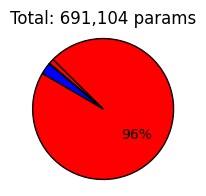

Epoch 10/10 - loss: 0.5170 - accuracy: 0.8717 - val_loss: 0.3898 - val_accuracy: 0.9230
The history has the following data:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


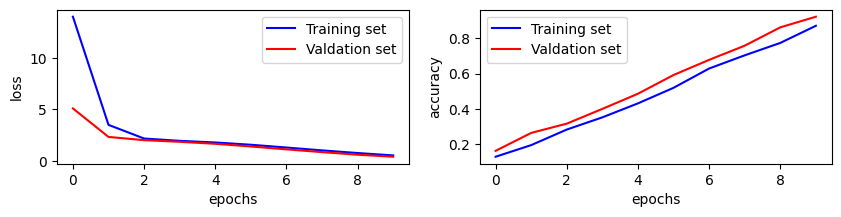

In [11]:
model = section2(dataset_folder='dataset2_small')
model.initialise_data_and_model()
model.train()
model.plot()

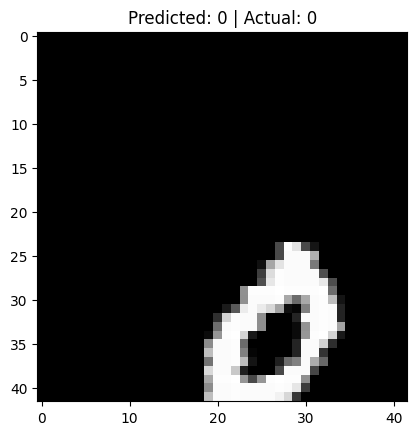

In [30]:
model.eval_random()

In [ ]:
conv_layers = [64,128,256,32]
dense_layers = [16,256,128]
target = 4
model = single_model()
params, time, iter = optimize(model=model, conv_layers=conv_layers, dense_layers=dense_layers, target=target, max_iter=10, random_factor=(0.9, 1.05), max_failed_trains=2)

In [ ]:
plot_results(params, time, iter)